In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
from sklearn import neighbors, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


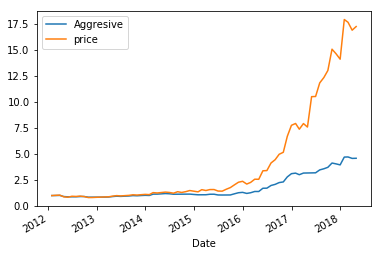

Predicted model accuracy: 61%


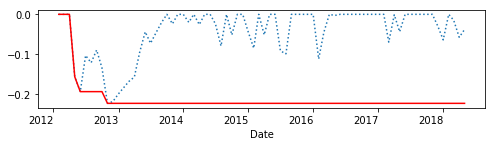


MDD : -22.2%
CAGR : 57.7%

For next Month:
wait for next chance


In [2]:
def price(stock, start):
    price = web.DataReader(name=stock, data_source='yahoo', start=start)['Adj Close']
    return price.div(price.iat[0]).resample('M').last().to_frame('price')
   
def fractal(a, p):
    df = pd.DataFrame()
    for count in range(1,p+1):
        a['direction'] = np.where(a['price'].diff(count)>0,1,0)
        a['abs'] = a['price'].diff(count).abs()
        a['volatility'] = a.price.diff().abs().rolling(count).sum()
        a['fractal'] = a['abs']/a['volatility']*a['direction']
        df = pd.concat([df, a['fractal']], axis=1)
    return df

a = price('NVDA','2010-01-01')
a['cash'] = [(1.03**(1/12))**x for x in range(len(a.index))]
a['meanfractal']= pd.DataFrame(fractal(a, 12)).sum(1,skipna=False)/12  
a['rollingstd'] = a.price.pct_change().shift(1).rolling(12).std()
a['result'] = np.where(a.price > a.price.shift(1), 1,0)    
a = a.dropna()



clf = neighbors.KNeighborsClassifier(n_neighbors=3)
clf1 = svm.SVC()
clf3 = RandomForestClassifier(n_estimators=5)

a['predicted']= pd.Series()
predictions = []
for i in range(12,len(a.index)):
    x  =  a.iloc[i-12:i,6:8]   
    y  =  a['result'][i-12:i]
    clf.fit(x, y)
    a['predicted'][i]= clf.predict(x)[-1]
#     print(clf.predict(x)[-1])
    predictions.append(clf.predict(x)[-1])

x1 = a.iloc[len(a.index)-12:len(a.index),6:8]
fit4 =clf.predict(x1)[-1]


a = a.dropna()
a.price = a.price.div(a.price.ix[0])

accuracy=clf.score(a.iloc[:,6:8],a['result'])

a['Aggresive'] = np.where(a.predicted.shift(1)==1,((a.price/a.price.shift(1))*0.7+(1.0026)*0.3),1.0026).cumprod()
a[['Aggresive','price']].plot()
plt.show()
print ("Predicted model accuracy: "+ str(accuracy)[2:4]+"%")

period = len(a.index)/12

md = a.price.rolling(min_periods=1, window = 500).max()
pmd = a.price/md - 1.0
mdd = pmd.rolling(min_periods=1, window=500).min()

pmd.plot(subplots=True, figsize = (8,2), linestyle='dotted')
mdd.plot(subplots=True, figsize = (8,2), color = 'red')
plt.show()

print("\nMDD : "+str(mdd.min()*100)[0:5]+"%")
print("CAGR : "+str(a.price[-1]**(1/period)*100-100)[0:4]+"%")

print('\nFor next Month:')
print('Do Invest') if fit4==1 else print('wait for next chance')